In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import sqlite3
import os
from datetime import datetime, timedelta

pd.options.display.float_format = '{:.2f}'.format 
np.set_printoptions(suppress=True)

In [2]:
data_folder = os.path.join(os.getcwd(), os.pardir, 'data')
db_path = os.path.join(data_folder, 'retail_chain.db')
pos_path = os.path.join(data_folder, 'point_of_sales_data.csv')
customer_path = os.path.join(data_folder, 'customer_data.csv')
product_path = os.path.join(data_folder, 'product_data.csv')

In [3]:
conn = sqlite3.connect(db_path)
c = conn.cursor()

In [4]:
c.execute("""create table if not exists pos_data (
          transaction_id, 
          customer_id, 
          store_id, 
          date, 
          category,
          product_name, 
          quantity, 
          payment_method, 
          discount_applied, 
          online_order
          )""")

pos_data = pd.read_csv(pos_path)
pos_data.to_sql('pos_data', conn, if_exists='replace', index = False)

1507583

In [5]:
c.execute("""create table if not exists customer_data (
          customer_id,
          age,
          gender
          )""")

customer_data = pd.read_csv(customer_path)
customer_data.to_sql('customer_data', conn, if_exists='replace', index = False)


776588

In [6]:
c.execute("""create table if not exists product_data (
          product_name,
          unit_price,
          category          
          )""")

product_data = pd.read_csv(product_path)
product_data.to_sql('product_data', conn, if_exists='replace', index = False)

800

In [7]:
query = """
select
transaction_id as 'Transaction ID', -- including transaction_id to detect duplicates
pos.customer_id as 'Customer ID',
age as 'Age',
gender as 'Gender',
store_id as 'Store',
date as 'Transaction Date',
pos.category as 'Category',
pos.product_name as 'Product',
unit_price as 'Unit Price (£)',
quantity as 'Quantity',
discount_applied as 'Discount Applied (%)',
round(unit_price * quantity * (1 - discount_applied / 100), 2) as 'Total Price (£)',
payment_method as 'Payment Method',
online_order as 'Online Order'
from pos_data pos
left join customer_data c on pos.customer_id = c.customer_id
left join product_data p on pos.product_name = p.product_name
"""
df = pd.read_sql_query(query, conn)

In [8]:
print(f'{df.shape[0]} rows and {df.shape[1]} columns')
df.head()

1507583 rows and 14 columns


,Transaction ID,Customer ID,Age,Gender,Store,Transaction Date,Category,Product,Unit Price (£),Quantity,Discount Applied (%),Total Price (£),Payment Method,Online Order
0,4f22d2c7-82ab-4c38-b1b2-23c15cd8840b,CUST_609725,41.00,F,Store_20,2024-09-08,Groceries,Groceries_Product_48,56.84,4,0,227.36,Credit Card,0
1,8766593d-5cde-45af-b246-48359c4a7782,CUST_820883,49.00,F,Store_26,2024-01-26,Electronics,Electronics_Product_55,5.20,9,0,46.80,Debit Card,0
2,e0d0fcf5-1ab5-4a97-88d2-3e619b152360,CUST_502855,37.00,M,Store_44,2024-07-22,Electronics,Electronics_Product_61,51.87,8,0,414.96,Cash,0
3,4f25f2c7-e00f-44ed-b734-07e2ac485de2,CUST_599464,19.00,M,Store_31,2024-08-28,Groceries,Groceries_Product_30,6.32,5,20,31.60,Credit Card,0
4,27d0222e-53c3-4427-a9f1-c379c009f8fe,CUST_556920,32.00,M,Store_23,2024-02-19,Clothing,Clothing_Product_180,87.43,7,15,612.01,Cash,0


In [9]:
old_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f'{old_rows - df.shape[0]} duplicate rows removed')
df.drop(columns=['Transaction ID'], inplace=True) # dropping transaction_id as it is not needed for analysis, only detecting duplicate transactions

7500 duplicate rows removed


In [10]:
def map_age_range(age):
    if age < 18:
        return 'Under 18'
    elif 18 <= age <= 24:
        return '18 to 24'
    elif 25 <= age <= 34:
        return '25 to 34'
    elif 35 <= age <= 44:
        return '35 to 44'
    elif 45 <= age <= 54:
        return '45 to 54'
    elif 55 <= age <= 64:
        return '55 to 64'
    elif 65 <= age <= 74:
        return '65 to 74'
    else:
        return 'Over 75'

df['Age Range'] = df['Age'].apply(map_age_range)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500083 entries, 0 to 1500082
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Customer ID           1500083 non-null  object 
 1   Age                   1485182 non-null  float64
 2   Gender                1455753 non-null  object 
 3   Store                 1500083 non-null  object 
 4   Transaction Date      1500083 non-null  object 
 5   Category              1500083 non-null  object 
 6   Product               1500083 non-null  object 
 7   Unit Price (£)        1500083 non-null  float64
 8   Quantity              1500083 non-null  int64  
 9   Discount Applied (%)  1500083 non-null  int64  
 10  Total Price (£)       1500083 non-null  float64
 11  Payment Method        1500083 non-null  object 
 12  Online Order          1500083 non-null  int64  
 13  Age Range             1500083 non-null  object 
dtypes: float64(3), int64(3), object(8)
memo

In [12]:
# Optimizing the data types as conscious of data size and memory usage
df['Age'] = df['Age'].replace(np.nan, round(df['Age'].mean())).astype('int8')
df['Gender'] = df['Gender'].fillna('Not Specified').astype('category')
df['Category'] = df['Category'].astype('category')
df['Product'] = df['Product'].astype('category')
df['Quantity'] = df['Quantity'].astype('int8')
df['Unit Price (£)'] = df['Unit Price (£)'].astype('float32')
df['Total Price (£)'] = df['Total Price (£)'].astype('float32')
df['Payment Method'] = df['Payment Method'].astype('category')
df['Discount Applied (%)'] = df['Discount Applied (%)'].astype('int8')
df['Online Order'] = df['Online Order'].astype('category')
df['Age Range'] = df['Age Range'].astype('category')

df.info() # checking memory usage after optimization

<class 'pandas.core.frame.DataFrame'>
Index: 1500083 entries, 0 to 1500082
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype   
---  ------                --------------    -----   
 0   Customer ID           1500083 non-null  object  
 1   Age                   1500083 non-null  int8    
 2   Gender                1500083 non-null  category
 3   Store                 1500083 non-null  object  
 4   Transaction Date      1500083 non-null  object  
 5   Category              1500083 non-null  category
 6   Product               1500083 non-null  category
 7   Unit Price (£)        1500083 non-null  float32 
 8   Quantity              1500083 non-null  int8    
 9   Discount Applied (%)  1500083 non-null  int8    
 10  Total Price (£)       1500083 non-null  float32 
 11  Payment Method        1500083 non-null  category
 12  Online Order          1500083 non-null  category
 13  Age Range             1500083 non-null  category
dtypes: category(6), float32

In [13]:
df['Category'].value_counts()

Category
Groceries      750192
Electronics    300053
Home Goods     225360
Clothing       224478
Name: count, dtype: int64

In [14]:
# Replace products with initials + product number, e.g., Groceries_Product_409 to G409
df['Product'] = df['Product'].replace({'Groceries_Product':'G','Clothing_Product_':'C','Electronics_Product_':'E','Home Goods_Product_':'HG'})

# Rounding Unit Price and Total Amount to 2 decimal places
df['Unit Price (£)'] = df['Unit Price (£)'].apply(lambda x: f'{x:.2f}').astype('float32')
df['Total Price (£)'] = df['Total Price (£)'].apply(lambda x: f'{x:.2f}').astype('float32')

In [15]:
df.head()

,Customer ID,Age,Gender,Store,Transaction Date,Category,Product,Unit Price (£),Quantity,Discount Applied (%),Total Price (£),Payment Method,Online Order,Age Range
0,CUST_609725,41,F,Store_20,2024-09-08,Groceries,Groceries_Product_48,56.84,4,0,227.36,Credit Card,0,35 to 44
1,CUST_820883,49,F,Store_26,2024-01-26,Electronics,Electronics_Product_55,5.20,9,0,46.80,Debit Card,0,45 to 54
2,CUST_502855,37,M,Store_44,2024-07-22,Electronics,Electronics_Product_61,51.87,8,0,414.96,Cash,0,35 to 44
3,CUST_599464,19,M,Store_31,2024-08-28,Groceries,Groceries_Product_30,6.32,5,20,31.60,Credit Card,0,18 to 24
4,CUST_556920,32,M,Store_23,2024-02-19,Clothing,Clothing_Product_180,87.43,7,15,612.01,Cash,0,25 to 34


In [16]:
# Change all transaction dates to format YYYY-MM-DD
wrong_format_nrows_old = df[df['Transaction Date'].str[4]!='-'].shape[0]
df['Transaction Date'] = df['Transaction Date'].str.replace('/','-')
mask = df['Transaction Date'].str.match(r'\d{2}-\d{2}-\d{4}')
df.loc[mask, 'Transaction Date'] = pd.to_datetime(df.loc[mask, 'Transaction Date'], dayfirst=True).dt.strftime('%Y-%m-%d')
wrong_format_nrows_new = df[df['Transaction Date'].str[4]!='-'].shape[0]
print(f'{wrong_format_nrows_old - wrong_format_nrows_new} dates reformatted')
df[df['Transaction Date'].str[4]!='-'] # Checking there are no Transaction Dates with the wrong format


29981 dates reformatted


,Customer ID,Age,Gender,Store,Transaction Date,Category,Product,Unit Price (£),Quantity,Discount Applied (%),Total Price (£),Payment Method,Online Order,Age Range


In [17]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')
df['Transaction Date'].dtype

dtype('<M8[ns]')

In [18]:
df.isna().sum()

Customer ID             0
Age                     0
Gender                  0
Store                   0
Transaction Date        0
Category                0
Product                 0
Unit Price (£)          0
Quantity                0
Discount Applied (%)    0
Total Price (£)         0
Payment Method          0
Online Order            0
Age Range               0
dtype: int64

In [19]:
total_revenue = df['Total Price (£)'].sum()
print(f'Total Revenue for 2024: £{total_revenue:,.2f}')

Total Revenue for 2024: £444,089,248.00


In [20]:
df_copy = df.copy()
df_copy['Year-Month'] = df_copy['Transaction Date'].dt.to_period('M') # Year-Month allows for scalability for including data for additional years
monthly_revenue = df_copy.groupby('Year-Month')['Total Price (£)'].sum()
max_month = monthly_revenue.idxmax()
max_month_rev = monthly_revenue.max()
min_month = monthly_revenue.idxmin()
min_month_rev = monthly_revenue.min()

print(f'Best month: {max_month} @ £{max_month_rev:,.2f}\nWorst month: {min_month} @ £{min_month_rev:,.2f}')

Best month: 2024-11 @ £55,707,972.00
Worst month: 2024-06 @ £1,270,910.12


In [21]:
monthly_revenue.index = monthly_revenue.index.to_timestamp()

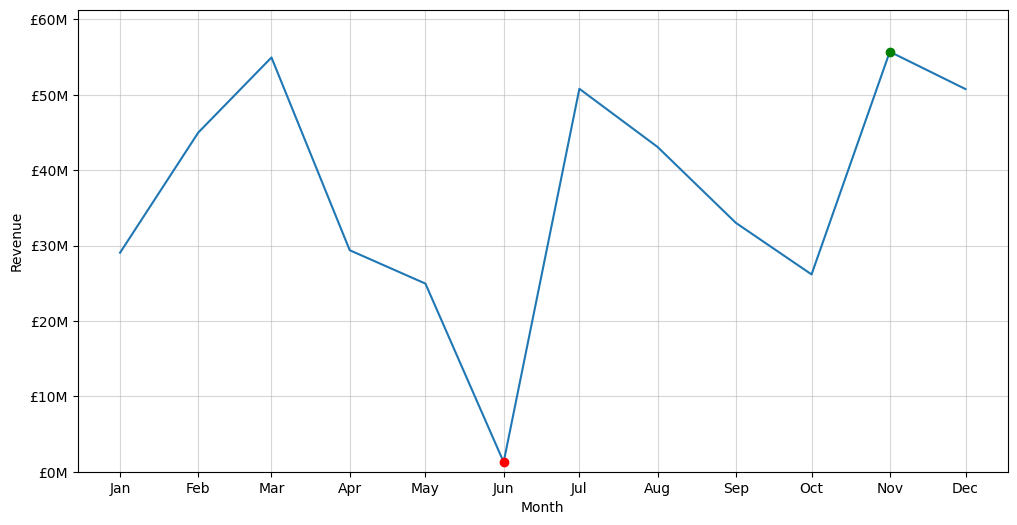

In [22]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(x=monthly_revenue.index, y=monthly_revenue.values,zorder=2)
plt.grid(visible=True,alpha=0.5,zorder=0)
ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks=range(len(ticks)), labels=ticks)
ax.set_xticks(monthly_revenue.index[monthly_revenue.index.month-1])  # Set the positions based on the datetime index
ax.set_xticklabels(ticks)

plt.xlabel('Month')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'£{x/1e6:,.0f}M'))
plt.ylabel('Revenue')
plt.ylim(0,monthly_revenue.max()*1.1)
ax.plot(monthly_revenue.index[5], monthly_revenue.iloc[5], 'ro',zorder=3)
ax.plot(monthly_revenue.index[10], monthly_revenue.iloc[10], 'go',zorder=3) 
plt.show()

In [23]:
cat_rev = df.groupby('Category', observed=False)['Total Price (£)'].sum()
max_cat = cat_rev.idxmax()
max_cat_rev = cat_rev.max()
min_cat = cat_rev.idxmin()
min_cat_rev = cat_rev.min()
cat_percentage = (cat_rev/cat_rev.sum())*100

print(f'Best category: {max_cat} @ £{max_cat_rev:,.2f}\nWorst category: {min_cat} @ £{min_cat_rev:,.2f}')
print(f'\n{cat_rev.sort_values(ascending=False).apply(lambda x: f'£{x:,.2f}')}')
print(f'\n{cat_percentage.sort_values(ascending=False).apply(lambda x: f'{x:,.2f}%')}')

Best category: Groceries @ £233,994,000.00
Worst category: Clothing @ £65,132,376.00

Category
Groceries      £233,994,000.00
Electronics     £76,798,544.00
Home Goods      £68,164,272.00
Clothing        £65,132,376.00
Name: Total Price (£), dtype: object

Category
Groceries      52.69%
Electronics    17.29%
Home Goods     15.35%
Clothing       14.67%
Name: Total Price (£), dtype: object


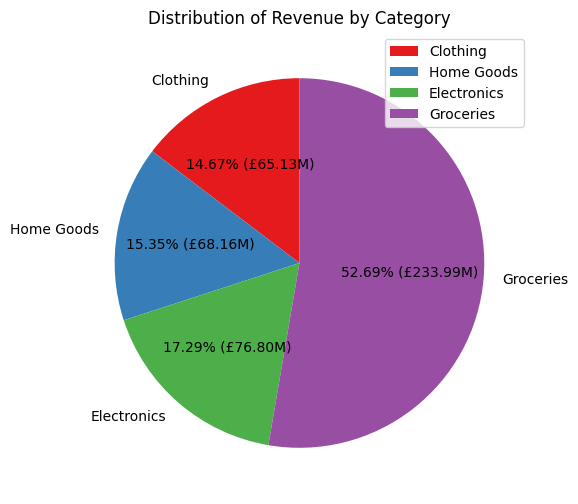

In [24]:
plt.figure(figsize=(12,6))
plt.pie(cat_rev.sort_values(ascending=True), labels=cat_rev.sort_values(ascending=True).index, autopct=lambda p:f'{p:.2f}% (£{p/100*total_revenue/1e6:.2f}M)', startangle=90, colors=plt.cm.Set1.colors)
plt.title('Distribution of Revenue by Category')
plt.legend()
plt.show()

In [25]:
AOV = total_revenue/df.shape[0]
print(f'Overall Average Order Value (AOV) of £{AOV:,.2f}')
store_rev = df.groupby('Store', observed=False)['Total Price (£)'].sum()
store_lb = store_rev.sort_values(ascending=False)
print(f'Highest performing store: {store_lb.index[0]} @ £{store_lb.iloc[0]:,.2f}\nLowest performing store: {store_lb.index[-1]} @ £{store_lb.iloc[-1]:,.2f}')
aov_per_store = [df['Total Price (£)'][df['Store']==store].sum()/df[df['Store']==store].shape[0] for store in store_lb.index]
store_AOV = pd.Series(aov_per_store, index=store_lb.index)
print(f'\nBest performing stores by AOV: \n{store_AOV.sort_values(ascending=False).apply(lambda x: f'£{x:,.2f}').head()}\n\nWorst performing stores by AOV: \n{store_AOV.sort_values(ascending=True).apply(lambda x: f'£{x:,.2f}').head()}')

Overall Average Order Value (AOV) of £296.04
Highest performing store: Store_40 @ £16,458,201.00
Lowest performing store: Store_8 @ £40,889.33

Best performing stores by AOV: 
Store
Store_29    £299.15
Store_12    £298.21
Store_30    £298.07
Store_34    £297.54
Store_31    £297.51
dtype: object

Worst performing stores by AOV: 
Store
Store_50    £289.90
Store_32    £292.40
Store_41    £292.76
Store_36    £293.62
Store_8     £294.17
dtype: object


In [26]:
aov_per_category = [df['Total Price (£)'][df['Category']==category].sum()/df[df['Category']==category].shape[0] for category in df['Category'].unique()]
category_AOV = pd.Series(aov_per_category, index=df['Category'].unique())
print(f'AOV per Category\n{category_AOV.sort_values(ascending=False).apply(lambda x: f'£{x:,.2f}')}')

AOV per Category
Groceries      £311.91
Home Goods     £302.47
Clothing       £290.15
Electronics    £255.95
dtype: object


In [27]:
store_rev_lb = store_rev.sort_values(ascending=False)
print(f'\nBest performing store by Total Revenue: \n{store_rev_lb.idxmax()} {store_rev_lb.apply(lambda x: f'£{x:,.2f}').iloc[0]}\nWorst performing store by Total Revenue: \n{store_rev_lb.idxmin()} {store_rev_lb.apply(lambda x: f'£{x:,.2f}').iloc[-1]}')


Best performing store by Total Revenue: 
Store_40 £16,458,201.00
Worst performing store by Total Revenue: 
Store_8 £40,889.33


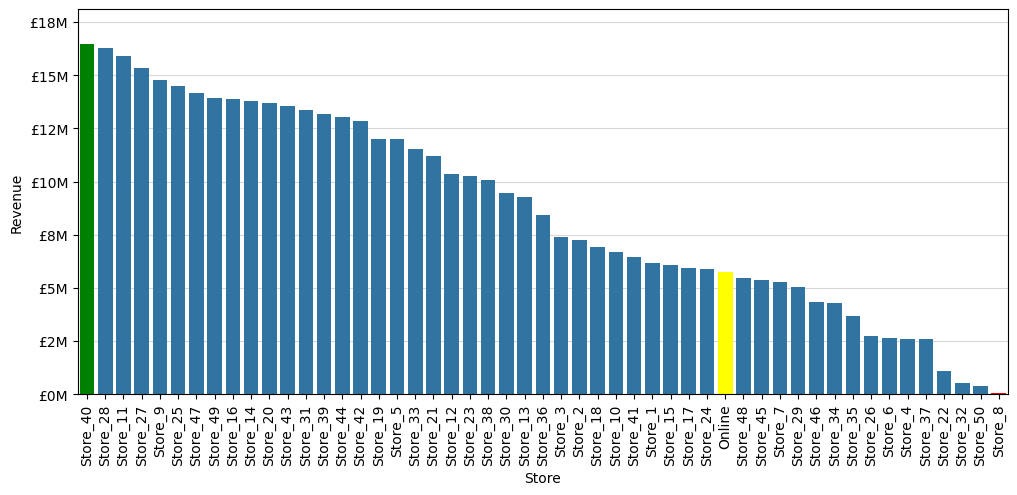

In [47]:
plt.figure(figsize=(12,5))
plt.grid(visible=True,alpha=0.5,zorder=0)
ax = sns.barplot(store_rev_lb,zorder=2)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'£{x/1e6:,.0f}M'))
plt.ylim(0, store_rev_lb.max()*1.1)
plt.xticks(ticks=range(len(store_rev_lb.index)), rotation=90)
ax.patches[0].set_facecolor('green')
ax.patches[50].set_facecolor('red')
ax.patches[35].set_facecolor('yellow')
plt.ylabel('Revenue')
plt.show()

In [29]:
discounted_df = df[df['Discount Applied (%)']>0]
print(f'{discounted_df.shape[0]:,} out of {df.shape[0]:,} transactions had discounts applied ({discounted_df.shape[0]/df.shape[0]*100:,.2f}%)')
average_discount = discounted_df['Discount Applied (%)'].sum()/discounted_df.shape[0]
print(f'The average discount rate was {average_discount:.2f}%')

360,577 out of 1,500,083 transactions had discounts applied (24.04%)
The average discount rate was 12.50%


In [30]:
store_discounts = discounted_df['Store'].value_counts()/df['Store'].value_counts()*100
print(f'Top 5 - percentage of transactions with discounts applied:\n{store_discounts.sort_values(ascending=False).apply(lambda x: f'{x:,.2f}%').head()}')
print(f'\nBottom 5 - percentage of transactions with discounts applied:\n{store_discounts.sort_values(ascending=True).apply(lambda x: f'{x:,.2f}%').head()}')

Top 5 - percentage of transactions with discounts applied:
Store
Store_8     28.78%
Store_32    24.91%
Store_41    24.49%
Online      24.46%
Store_34    24.43%
Name: count, dtype: object

Bottom 5 - percentage of transactions with discounts applied:
Store
Store_50    22.44%
Store_29    23.59%
Store_28    23.65%
Store_42    23.72%
Store_35    23.74%
Name: count, dtype: object


In [31]:
disc_total_rev = discounted_df['Total Price (£)'].sum()
extra_rev = (disc_total_rev*(1+average_discount/100))-disc_total_rev
print(f'Discounted transactions total £{disc_total_rev:,.2f}, making up {disc_total_rev/total_revenue*100:,.2f}% of total revenue')
print(f'Extra revenue if not discounted: £{extra_rev:,.2f}, reducing the profit margin by {extra_rev/total_revenue*100:,.2f}%')

Discounted transactions total £106,915,648.00, making up 24.08% of total revenue
Extra revenue if not discounted: £13,362,298.87, reducing the profit margin by 3.01%


In [32]:
online_df = df_copy[df_copy['Online Order']==1]
online_rev = online_df['Total Price (£)'].sum()
print(f'Online orders made up {online_df.shape[0]/df.shape[0]*100:,.2f}% of all orders ({online_df.shape[0]:,} Online Orders)')
print(f'Online orders generated £{online_rev:,.2f} of revenue, {online_rev/total_revenue*100:,.2f}% of total revenue')
online_month = online_df.groupby('Year-Month')['Total Price (£)'].sum()
online_month

Online orders made up 1.30% of all orders (19,468 Online Orders)
Online orders generated £5,727,611.00 of revenue, 1.29% of total revenue


Year-Month
2024-01   396307.62
2024-02   584133.69
2024-03   677121.38
2024-04   403969.44
2024-05   309183.78
2024-06    20764.53
2024-07   640877.62
2024-08   555083.06
2024-09   420792.97
2024-10   348977.97
2024-11   702242.75
2024-12   668156.00
Freq: M, Name: Total Price (£), dtype: float32

In [33]:
online_cat = online_df.groupby('Category', observed=False)['Total Price (£)'].sum()
online_cat_sorted = online_cat.sort_values(ascending=False)
print(f'Distribution of Revenue by Category - Online Orders only\n{online_cat_sorted.apply(lambda x: f'£{x:,.2f}')}')
print(f'\nDistribution of Revenue by Category - Online Orders only\n{(online_cat_sorted/online_cat_sorted.sum()*100).apply(lambda x: f'{x:,.2f}%')}')

Distribution of Revenue by Category - Online Orders only
Category
Groceries      £3,015,001.50
Electronics    £1,014,980.44
Home Goods       £867,078.88
Clothing         £830,550.00
Name: Total Price (£), dtype: object

Distribution of Revenue by Category - Online Orders only
Category
Groceries      52.64%
Electronics    17.72%
Home Goods     15.14%
Clothing       14.50%
Name: Total Price (£), dtype: object


In [34]:
online_copy = online_df.copy()
online_copy['Year-Month'] = online_copy['Transaction Date'].dt.to_period('M') # Year-Month allows for scalability for including data for additional years
online_monthly_revenue = online_copy.groupby('Year-Month')['Total Price (£)'].sum()
online_max_month = online_monthly_revenue.idxmax()
online_max_month_rev = online_monthly_revenue.max()
online_min_month = online_monthly_revenue.idxmin()
online_min_month_rev = online_monthly_revenue.min()

print(f'Best month: {online_max_month} @ £{online_max_month_rev:,.2f}\nWorst month: {online_min_month} @ £{online_min_month_rev:,.2f}')

Best month: 2024-11 @ £702,242.75
Worst month: 2024-06 @ £20,764.53


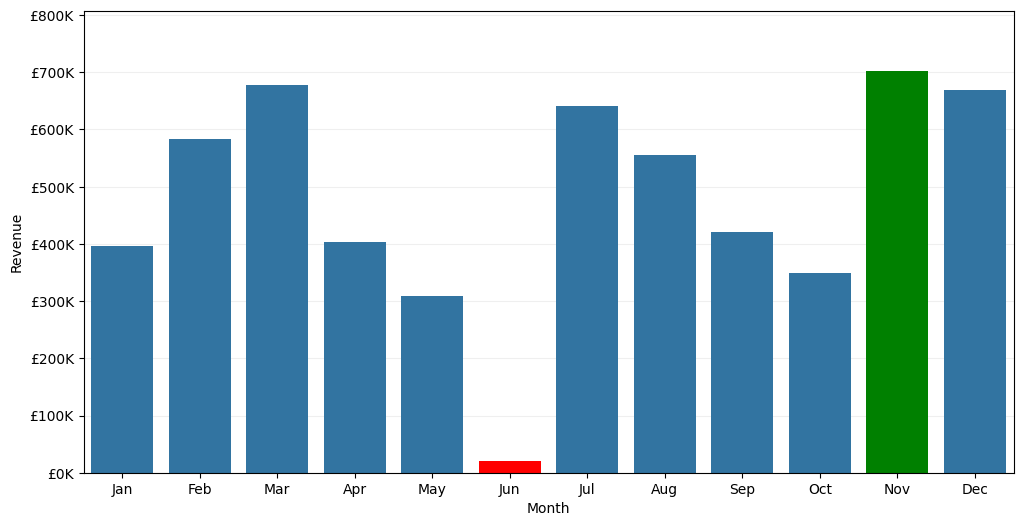

In [35]:
plt.figure(figsize=(12,6))
plt.grid(visible=True, alpha=0.2, zorder=0)
ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax = sns.barplot(data=online_monthly_revenue, zorder=2)
plt.xticks(ticks=range(len(ticks)), labels=ticks)
plt.xlabel('Month')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'£{x/1e3:,.0f}K'))
plt.ylabel('Revenue')
plt.ylim(0,online_monthly_revenue.max()*1.15)
ax.patches[5].set_facecolor('red')
ax.patches[10].set_facecolor('green')
plt.show()

C:\Users\Sammy\AppData\Local\Temp\ipykernel_23960\2147189918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_customers['Age Range'] = df_unique_customers['Age'].apply(map_age_range)


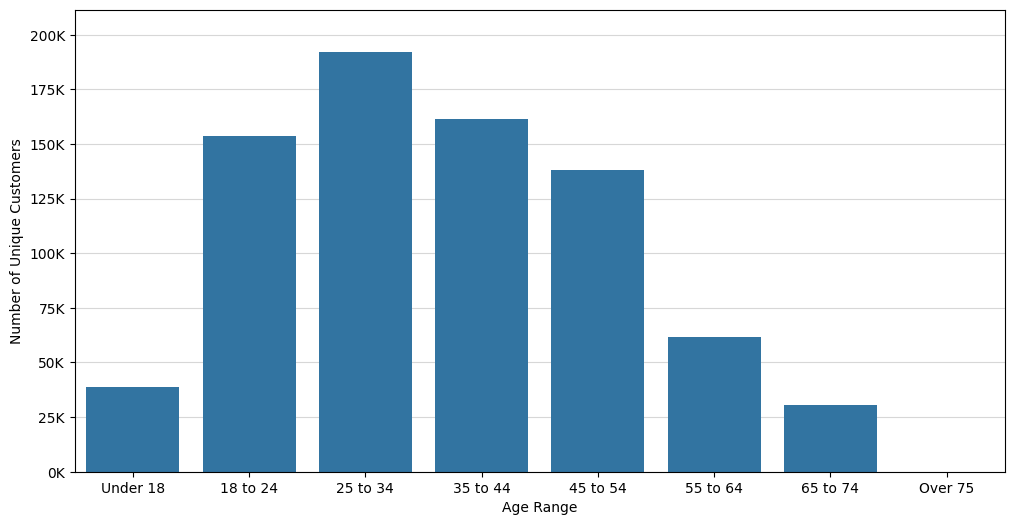

In [36]:
df_unique_customers = df.drop_duplicates(subset=['Customer ID'])
df_unique_customers['Age Range'] = df_unique_customers['Age'].apply(map_age_range)

order = ['Under 18', '18 to 24', '25 to 34', '35 to 44', '45 to 54', '55 to 64', '65 to 74', 'Over 75']

plt.figure(figsize=(12,6))
plt.grid(visible=True, alpha=0.5, zorder=0)
sns.barplot(x=df_unique_customers['Age Range'].value_counts().index, 
            y=df_unique_customers['Age Range'].value_counts().values, 
            order=order, zorder=2)

plt.ylim(0, df_unique_customers['Age Range'].value_counts().max() * 1.1)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e3:,.0f}K'))
plt.xlabel('Age Range')
plt.ylabel('Number of Unique Customers')
plt.show()

In [37]:
age_rev = df.groupby('Age Range', observed=False)['Total Price (£)'].sum()
print(f'Distribution of Revenue by Age\n{age_rev.sort_values(ascending=False).apply(lambda x: f'£{x:,.2f}')}')
print(f'\nDistribution of Revenue by Age\n{(age_rev.sort_values(ascending=False)/age_rev.sort_values(ascending=False).sum()*100).apply(lambda x: f'{x:,.2f}%')}')

Distribution of Revenue by Age
Age Range
25 to 34    £109,961,600.00
35 to 44     £88,076,920.00
18 to 24     £87,678,216.00
45 to 54     £79,034,200.00
55 to 64     £35,199,356.00
Under 18     £22,119,382.00
65 to 74     £17,628,980.00
Over 75       £4,390,540.00
Name: Total Price (£), dtype: object

Distribution of Revenue by Age
Age Range
25 to 34    24.76%
35 to 44    19.83%
18 to 24    19.74%
45 to 54    17.80%
55 to 64     7.93%
Under 18     4.98%
65 to 74     3.97%
Over 75      0.99%
Name: Total Price (£), dtype: object


In [38]:
aov_per_age = [df['Total Price (£)'][df['Age Range']==age].sum()/df[df['Age Range']==age].shape[0] for age in df['Age Range'].unique()]
age_AOV = pd.Series(aov_per_age, index=df['Age Range'].unique())
print(f'AOV per Age Range\n{age_AOV.sort_values(ascending=False).apply(lambda x: f'£{x:,.2f}')}')

AOV per Age Range
Under 18    £296.88
65 to 74    £296.85
35 to 44    £296.31
18 to 24    £296.09
25 to 34    £295.85
45 to 54    £295.77
55 to 64    £295.69
Over 75     £294.65
dtype: object


C:\Users\Sammy\AppData\Local\Temp\ipykernel_23960\2629569395.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_gender_rev = df.groupby(['Category', 'Gender'])['Total Price (£)'].sum().reset_index()


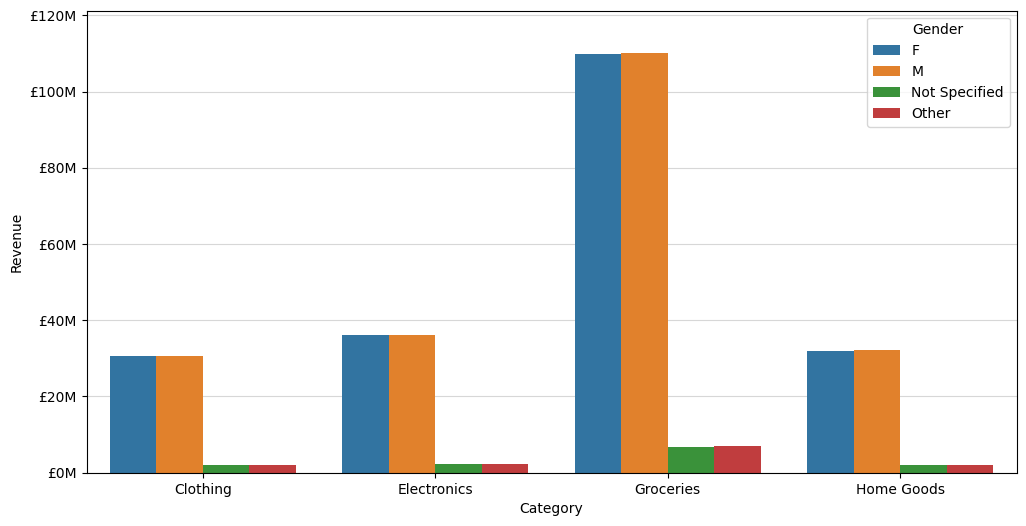

In [39]:
category_gender_rev = df.groupby(['Category', 'Gender'])['Total Price (£)'].sum().reset_index()
plt.figure(figsize=(12,6))
plt.grid(visible=True,alpha=0.5,zorder=0)
sns.barplot(category_gender_rev, x='Category',y='Total Price (£)', hue='Gender',zorder=2)
plt.ylim(0,category_gender_rev['Total Price (£)'].max()*1.1)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'£{x/1e6:,.0f}M'))
plt.ylabel('Revenue')
plt.show()

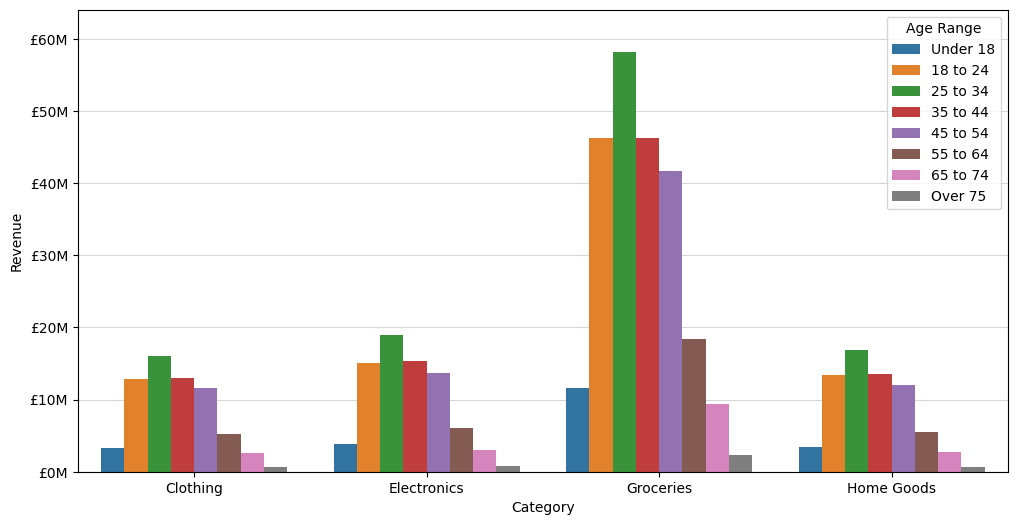

In [40]:
category_age_rev = df.groupby(['Category', 'Age Range'], observed=False)['Total Price (£)'].sum().reset_index()
plt.figure(figsize=(12,6))
plt.grid(visible=True,alpha=0.5,zorder=0)
sns.barplot(category_age_rev, x='Category',y='Total Price (£)', hue='Age Range', hue_order=order, zorder=2)
plt.ylim(0,category_age_rev['Total Price (£)'].max()*1.1)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'£{x/1e6:,.0f}M'))
plt.ylabel('Revenue')
plt.show()

In [41]:
print(f'{df['Payment Method'].value_counts()['Credit Card']/df['Payment Method'].value_counts().sum()*100:,.2f}% of transactions were paid via Credit Card')
print(f'{df['Payment Method'].value_counts()['Digital Wallet']/df['Payment Method'].value_counts().sum()*100:,.2f}% of transactions were paid via Digital Wallet')


40.04% of transactions were paid via Credit Card
10.03% of transactions were paid via Digital Wallet


In [42]:
for method in df['Payment Method'].unique():
    print(f'{method} has average order value of £{(df[df['Payment Method']==method]['Total Price (£)'].sum())/df[df['Payment Method']==method].shape[0]:,.2f}')

Credit Card has average order value of £296.50
Debit Card has average order value of £295.88
Cash has average order value of £295.62
Digital Wallet has average order value of £295.84


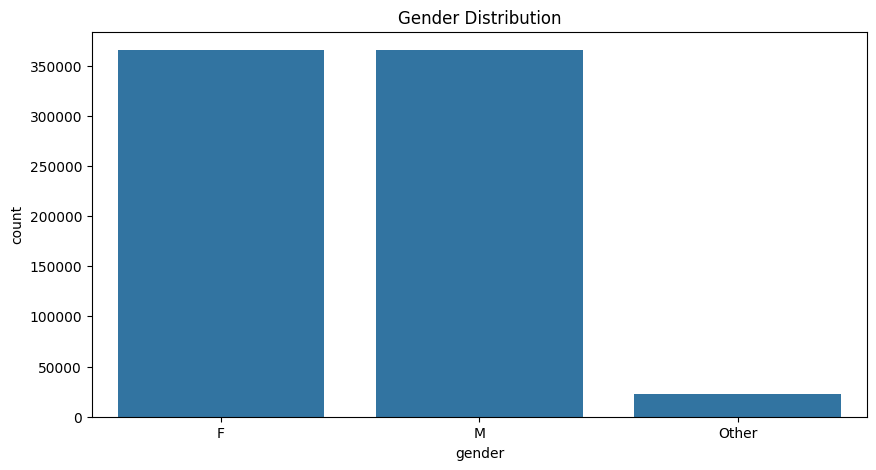

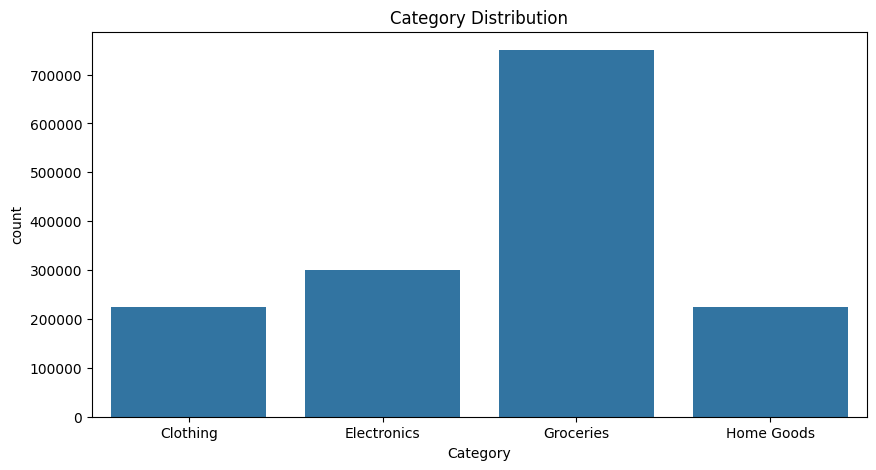

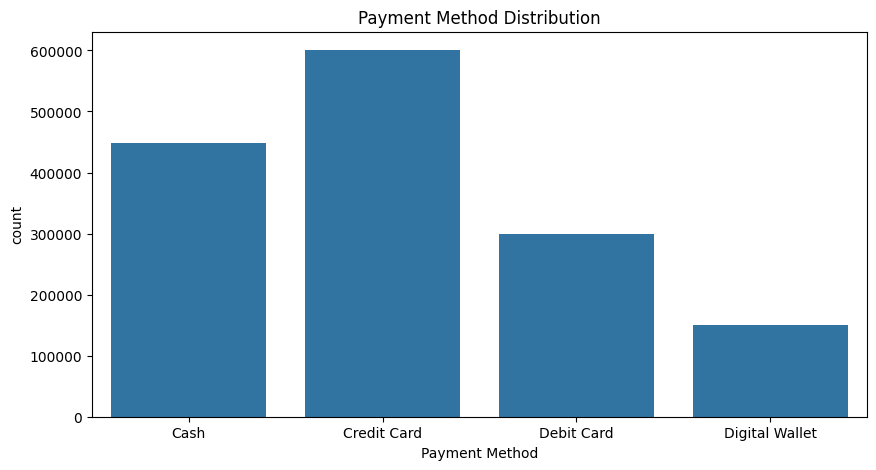

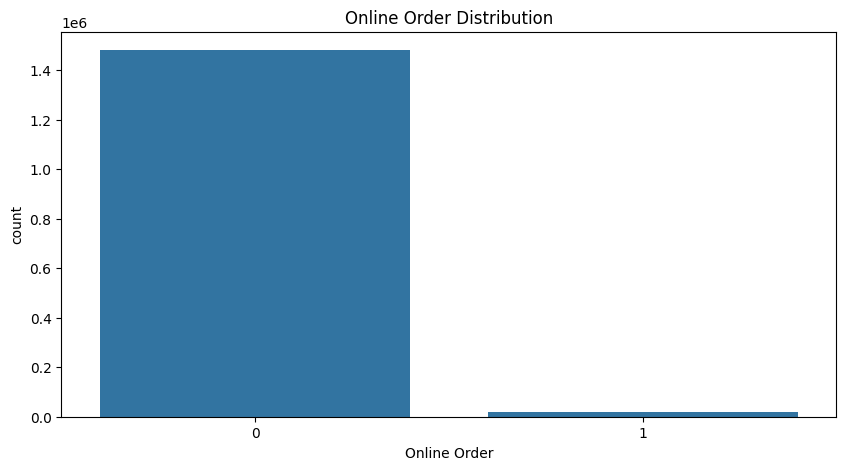

In [43]:
categorical_cols = ['Gender','Category','Payment Method','Online Order']
for col in categorical_cols:
    if col == 'Gender':
        plt.figure(figsize=(10,5))
        sns.countplot(data=customer_data, x='gender')
        plt.title(f'{col} Distribution')
        plt.show()
    else:
        plt.figure(figsize=(10,5))
        sns.countplot(data=df, x=col)
        plt.title(f'{col} Distribution')
        plt.show()